# Pendulum script

In [1]:
# a few packages we need to import

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.animation as animation
import IPython

NUMBER_STATES = 2
NUMBER_CONTROLS = 1

MAX_VELOCITY = 6.

DELTA_T = 0.1

## internal constants - DO NOT USE
_INTERNAL_DT = 0.01
_INTEGRATION_RATIO = 10
_GRAVITY = 9.81


def get_next_state(x,u):
    """
    This function integrates the pendulum for one step of DELTA_T seconds
    Inputs:
    x: state of the pendulum (theta,omega) as a 2D numpy array
    u: control as a scalar
    Output:
    the state of the pendulum as a 2D numpy array at the end of the integration
    """
    x_next = x[0]
    v_next = x[1]
    for i in range(_INTEGRATION_RATIO):
        xx_next = (x_next + _INTERNAL_DT * v_next)%(2*np.pi)
        v_next = np.clip(v_next + _INTERNAL_DT * (u-_GRAVITY*np.sin(x_next)-0.2*v_next), -MAX_VELOCITY, MAX_VELOCITY)
        x_next = xx_next
    return np.array([x_next,v_next])


def simulate(x0, policy, T):
    """
    This function simulates the pendulum for T seconds from initial state x0 using a policy (i.e. a function of x). It means that policy is called as policy(x) and returns one control)
    Inputs:
    x0: the initial conditions of the pendulum as a 2D array (angle and velocity)
    policy: a function that get a state as an input and return a scalar
    T: the time to integrate for
    Output:
    x (2D array) and u (1D array) containing the time evolution of states and control
    """
    horizon_length = int(T/DELTA_T)
    x=np.empty([2, horizon_length+1])
    x[:,0] = x0
    u=np.empty([horizon_length])
    t = np.zeros([horizon_length+1])
    for i in range(horizon_length):
        u[i] = policy(x[:,i])
        x[:,i+1] = get_next_state(x[:,i], u[i])
        t[i+1] = t[i] + DELTA_T
    return t, x, u


def animate_robot(x):
    """
    This function makes an animation showing the behavior of the pendulum
    takes as input the result of a simulation - dt is the sampling time (0.1s normally)
    """

    # here we check if we need to down-sample the data for display
    #downsampling (we want 100ms DT or higher)
    steps = 1
    use_dt = int(DELTA_T * 1000)
    plotx = x[:,::steps]

    fig = matplotlib.figure.Figure(figsize=[6,6])
    matplotlib.backends.backend_agg.FigureCanvasAgg(fig)
    ax = fig.add_subplot(111, autoscale_on=False, xlim=[-1.3,1.3], ylim=[-1.3,1.3])
    ax.grid()

    list_of_lines = []

    #create the cart pole
    line, = ax.plot([], [], 'k', lw=2)
    list_of_lines.append(line)
    line, = ax.plot([], [], 'o', lw=2)
    list_of_lines.append(line)

    def animate(i):
        for l in list_of_lines: #reset all lines
            l.set_data([],[])

        x_pend = np.sin(plotx[0,i])
        y_pend = -np.cos(plotx[0,i])

        list_of_lines[0].set_data([0., x_pend], [0., y_pend])
        list_of_lines[1].set_data([x_pend, x_pend], [y_pend, y_pend])

        return list_of_lines

    def init():
        return animate(0)


    ani = animation.FuncAnimation(fig, animate, np.arange(0, len(plotx[0,:])),
        interval=use_dt, blit=True, init_func=init)
    plt.close(fig)
    plt.close(ani._fig)
    IPython.display.display_html(IPython.core.display.HTML(ani.to_html5_video()))

# Q-learning

Function `get_cost(x,u)` that returns the current cost $g(x, u)$ as a function of the current state and control.

In [2]:
def get_cost(x, u):
  theta = x[0]
  omega = x[1]
  J_curr = (theta-np.pi)**2 + 0.01*(omega**2) + 0.0001*(u**2)
  return J_curr


Function `get_policy_and_value_function(q_table)` that computes both given a Q-table as an input.

In [3]:
def get_positions_in_qtable(state):
  '''INPUT: state = [theta, omega]
    OUTPUT: index_in_discretized_theta = index of closest discretized theta in q-table
            index_in_discretized_omega = index of closest discretized omega in q-table
  '''
  theta = state[0]
  omega = state[1]

  # we can find the index of the closest element in the set of discretized states
  index_in_discretized_theta = np.argmin(np.abs(DISCRETIZED_THETA - theta))
  index_in_discretized_omega = np.argmin(np.abs(DISCRETIZED_OMEGA - omega))

  return index_in_discretized_theta, index_in_discretized_omega

def get_policy_and_value_function(q_table):
  '''INPUT: q_table
    OUTPUT: opt_policy = An array of size (DISCRETE_WINDOWS, DISCRETE_WINDOWS)
                        with each index corresponding to the optimal control
                        input for that state
            value_function = An array of size (DISCRETE_WINDOWS, DISCRETE_WINDOWS)
                            with each index corresponding to the value function
                            for that state
  '''
  opt_policy = np.zeros([DISCRETE_WINDOWS, DISCRETE_WINDOWS])
  value_function = np.zeros_like(opt_policy)

  for i in range(len(DISCRETIZED_THETA)):
    for j in range(len(DISCRETIZED_OMEGA)):
      # Find control input with minimum Q-value i.e. optimal control value
      cntr_idx = np.argmin(q_table[i][j])
      u_opt = CONTROLS[cntr_idx]
      opt_policy[i, j] = u_opt
      value_function[i, j] = np.min(q_table[i][j])

  return opt_policy, value_function

Function `q_learning(q_table)` that implements the tabular Q-learning algorithm (using episodes of 100 timesteps and an epsilon greedy policy with $\epsilon = 0.1$). The function gets as an input an initial Q-table and returns a learned Q-table of similar size.

In [4]:
def q_learning(q_table):
  '''INPUT: q_table = initialized unlearned Q-table
    OUTPUT: q_table = learned Q-table
            cost_per_episode = cost of the policy for each episode

  '''
  cost_per_episode = []
  for episode in range(EPISODES):
    # Initialize states every episode
    x = INITIAL_STATE
    x_d = get_positions_in_qtable(x)
    cost_of_episode = 0

    # Update the Q-table
    for i in range(HORIZON_LENGTH):

      # Epsilon greedy policy
      if np.random.random() > EPSILON:
        cntr_idx = np.argmin(q_table[x_d[0]][x_d[1]])
      else:
        cntr_idx = np.random.randint(0, 2.1)

      # Calculating control input for current stage
      control_curr = CONTROLS[cntr_idx]

      # Calculating stage cost
      cost_curr = get_cost(x, control_curr)

      # Calculating next state
      x_next = get_next_state(x, control_curr)
      x_d_next = get_positions_in_qtable(x_next)

      # Extracting Q-values for current and next state
      min_Q_next = np.min(q_table[x_d_next[0]][x_d_next[1]])
      Q_curr = q_table[x_d[0]][x_d[1]][cntr_idx]

      #TD Error
      TD_error = cost_curr + DISCOUNT*min_Q_next - Q_curr

      # Update step
      Q_curr_updated = Q_curr + LEARNING_RATE*TD_error
      q_table[x_d[0]][x_d[1]][cntr_idx] = Q_curr_updated

      # Adding cost per stage to get total cost of the episode
      cost_of_episode = cost_of_episode + DISCOUNT*get_cost(x, control_curr)

      # Passing the baton
      x_d = x_d_next
      x = x_next

    # Recording the cost of each episode
    cost_per_episode.append(cost_of_episode)

    # Indicates whether the desired state has been reached or not
    #if (x[0] > 3 and x[0] < 3.2) and (x[1] >= 0 and x[1] < 0.1):
    #  print('We reached on episode', episode)

  return q_table, cost_per_episode

def policy(x):
  th, w = get_positions_in_qtable(x)
  u = POLICY[th, w]
  return u

## Implemented code

In [5]:
DISCOUNT = 0.99
LEARNING_RATE = 0.1
EPSILON = 0.1
EPISODES = 10000
SIMULATION_TIME = 10
HORIZON_LENGTH = int(SIMULATION_TIME/DELTA_T)              # time = 10 seconds divided by delta_t = 0.1
INITIAL_STATE = [0, 0]

DISCRETE_WINDOWS = 50                                     # if increasing this, also increase EPISODES for a good result
DISCRETIZED_THETA = np.linspace(0, 2*np.pi, DISCRETE_WINDOWS, endpoint=False)
DISCRETIZED_OMEGA = np.linspace(-6, 6, DISCRETE_WINDOWS)
CONTROLS = [-4, 0, 4]

In [6]:
# Initializing Q-table
q_table = np.random.uniform(0, 2, size=(DISCRETE_WINDOWS, DISCRETE_WINDOWS, 3))

# Q-learning
learned_q_table, cost_per_episode = q_learning(q_table)

# Calculating the optimal policy and optimal value function
POLICY, VALUE_FUNCTION = get_policy_and_value_function(learned_q_table)

# Simulating the optimal policy
t, x, u = simulate(INITIAL_STATE, policy, SIMULATION_TIME)

# Visualizing the results
animate_robot(x)

<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAAhTZtZGF0AAACrgYF//+q
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2MyByMzA2MCA1ZGI2YWE2IC0gSC4yNjQvTVBF
Ry00IEFWQyBjb2RlYyAtIENvcHlsZWZ0IDIwMDMtMjAyMSAtIGh0dHA6Ly93d3cudmlkZW9sYW4u
b3JnL3gyNjQuaHRtbCAtIG9wdGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFs
eXNlPTB4MzoweDExMyBtZT1oZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVk
X3JlZj0xIG1lX3JhbmdlPTE2IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBk
ZWFkem9uZT0yMSwxMSBmYXN0X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTMg
bG9va2FoZWFkX3RocmVhZHM9MSBzbGljZWRfdGhyZWFkcz0wIG5yPTAgZGVjaW1hdGU9MSBpbnRl
cmxhY2VkPTAgYmx1cmF5X2NvbXBhdD0wIGNvbnN0cmFpbmVkX2ludHJhPTAgYmZyYW1lcz0zIGJf
cHlyYW1pZD0yIGJfYWRhcHQ9MSBiX2JpYXM9MCBkaXJlY3Q9MSB3ZWlnaHRiPTEgb3Blbl9nb3A9
MCB3ZWlnaHRwPTIga2V5aW50PTI1MCBrZXlpbnRfbWluPTEwIHNjZW5lY3V0PTQwIGludHJhX3Jl
ZnJlc2g9MCByY19sb29rYWhlYWQ9NDAgcmM9Y3JmIG1idHJlZT0xIGNyZj0yMy4wIHFjb21wPTAu
NjAgcXBtaW49MCBxcG1heD02OSBxcHN0ZXA9NCBpcF9yYXRpbz0xLjQwIGFxPTE6MS4wMACAAAAN
GGWIhAA///73aJ8Cm1pDeoDklcUl20+B/6tncHyP6QMAAAMAAAMAABW3pGWGQnQv8mIAAAV8ALIG
ZJnpcUkTgA8wx7J03TT8KodCGFz3ILMf1XToD7aSZN8Zs9uaEA9jcSCQE44zxR7Qj2Eksq8+z+Wq
ZvqhqAmjtIUGvU4G5QJBAUbbGyaCYw38oY0EiqMUzXsdmysQKkUzaDNvexFsZpfdheEoKgGvZW8G
2fPtzPJdE33RzWsoHAbqHv7LUb1Fy2Yp1iQ19n08hwvr7IO0kg4fVQgC6P3/C57Zm0TDpNKoFwov
x46ywGgxxfs9fMlSyts++IhsON1YTXSZ+7DpOh9xNtWwLsYWvRnBU9gf4A7JwBQWOYAYmT3lcVdH
EKo8nPrWs29KQIrElzYOcOrbfLWcYFnRbvHGqlT+KBEQp3z6oWoiYMnqr8QIiolEN4vX5b2C+zQH
zQ2fvvWqjUvqvwklaEjJ+ye8BI4h+X6tXM23SjarA7G2VWJeukUYV1f6En/4Djaes3NIi9ChsJvV
ZhX7Rpm2Il8+frDU+8bix21f4FPyGkoTH6Uajh/DuATU5DNYJFJ/9Q2Np2xlEu8a69hQoJ3BMSRZ
+ik+prV10KxzWeUg9fl/KzQf3QipvP+pg7wAFlohaNC+X9u9nLEzN5JalqkEgZ+C32PFL8apw+fm
rMvkKu3kze1cjvQ9eb1WVr8dVoLGA8gIj3PoH2Ekq5xdue6W/RPHemBYaSrjMImhRINBsxMqkc/X
64/3PxBmibzh/kNToF5dW+0ebh2MXbcGVAp2FfYRRK2aYbo3TxcagBW4xbvasopU3pV0dGCwc2vH
cxHioMyADERF1ShDsFdEmvgFfmyg9mr/ByOiWrqxOLU68sMG3IEs+zM3q2I9xRoyF5jHSJXrtoTN
l/8FSqb+WEC3xvMph2wn3+VzO2oLGJs+s2PmjIafcLREQoBFCPbNU5yMZD4UzNk7brrVkZDIMXOK
KvXbDRsIKsSs89afBrDC1TgRwPIxx/LU72e6n74sxOP/2/lwYrCx4uuoMoMtHLvZJ5bHRfU9LauA
HkSiKK1fPazJfd9m0vt5cY2n0sZ+ZBm82f/yRA1gvKKSsfAW2cv83AvPMXXCotilGbuWdBwArTwN
SXLtEoa6cJftx8Ros7Zgt160RS035YYgxR6C2UDRbE0Gjj9o+Fxt2FcrSeFVkoA7s1P9AAv/5jHk
GQu3xx8oPJKCosXvkGAg5QmHSJvY8+mihwp7YoSNHtIKNLavE+2AGTYRd2EkPlDbBe79z2sK2GzW
NIQa5KoTBXE7sZs3X34s10Rr1O9mWFyxx8ZByvTKE4cqyaIaGolepyLG5tdMu7I9aRxfuTbLaaRK
YW/4zeHsFbwXwrIG2r5K6xu3tLQpyuc2aAjtrn1H00FYc1TZvMV/wxAvQNsGZhvdlh1gOWPXPsfZ
B/5Knsx74gDvbJaUG+Rsb6rk6exdyI4oib/SQOF+0lmSw9cs/Cy52k/6czOVzea57QlMtNAMir+R
BsNB9Vp4+Jzyo030YxqgAZ1RVEuJeJV5WXhsZs2Ys27AKSkboikrgA35CkxiSDw2HlX9/Mr7VRUZ
2ZWEed+J+0DDQ+LXOmDVxo7TgCD8+cAhT3C1gRbH/6zPVVLQmsHbIjDm9JwwGU4qnbvcZ/tlmXPL
TbFPy7fnYbzKG9Mj64YwC6Uii1awxulK6s+wDJSdn9sagJ7TljZkgGha0Mm9VUVCvWs0vCz8fdb1
BSkHDfr9L24fEhO+3SVLBzat1QlhvgCOolyrmxS4x52X754NACqWf9BFtxXjA3AMmWvxnYaFBjR6
uTHArNUJMHSH75HtSfZAJ1IWuojSVFVQbru4UGgLGKk3/PluX83q96Meq64uPQ3AG1IcC9/g7orw
W1L8ZWc86HZAYlmpo12jtauTGhzJ3vE8EJQ50E40ZipAGlA9351xS9AdZHn4X0uAVmqrnQTmi3hX
ZRG3nLnsumno3PR096losUXKe/TX57338MGdhfZlPiJ0xmrhjvaB4RVYxljnCEKBK5/JnnMHl8sO
qtKpPmVYqwovK9OJjhMhcSHtFi/rjGJMvydt7oombIpgrhe9bW6uwVtjhUCc/+R/LIvvXFnqxDoq
2JaAsR2Xc/chAfD/991xkjekahreDd5dcD4jF0+bCNIkhuWhkSwjTc9gEx+lVEK2T9NqN98tC6Pm
vypRMZhNirJS4LirYBsCz8n/5MPXNTSyk/5X4jFVtXqhpMuQaPu7hiTt1KxdtALEAutin+e6EbWv
35KCiQu/4G4+O4HGgX5JXn5Y5eNcl8S+VkPorHOhRAjz/1eu+T/J49TgQ4aO9D2nVvVdg7sB+XZ3
xDNXc+DNglBY3lVX4U6vPsYsW1/S6vGU1m2+T9G+SOgtbLgAAcUrfWP0DLiNYV6Xqce5N4J83As2
UyQ8iX8hrZv4cZ6c8TX5a6aHNEpvWK1FQ1IgY7+Fy23HcGNKI3w/7iCxV60zwbr0oaWX6R2i8elm
yDcXYmH349WKiQD4+l38HmcfkX9NXjX8kImg01nuXoA8GAZ1D1L3RqOU5qWe1QKP4711x/cqeg9h
65hLNU7YzlRqGQ8exkuwfmvwENLhNjC2BzHGUdMAMvPa/VGq2PmC8/NzfKZZsduKOmdgJ4neF3bC
9UCA2kKqBSajAq7b6A3TCuQWifaaAhQKVaXRYYuxdRmQRjDIJGgEetHCFMRNI3nZi+a92W6zDPEi
FGm/V0gLJBF8OgqmS+nbHjcBP6C/8YMQjVlV2zluzJEeN0KhLQWoLcJRJe6QvOCvE5mFTmtoONgu
MvXhqTZf/dZpeWApp3aaXZHvjUGCcOKatM/di4EPP5TBqrbMNEPwrdeq04u/DWrZ2zHeMlxiWdqF
i/TW3J1rS6URlLeyytFDe

Text(0.5, 0, 'Episodes')

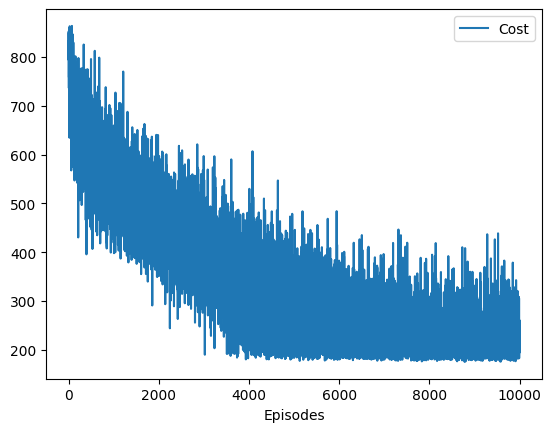

In [7]:
# we can plot the cost per episode
plt.figure()
plt.plot(cost_per_episode)
plt.legend(['Cost'])
plt.xlabel('Episodes')

Text(0.5, 1.0, 'Policy')

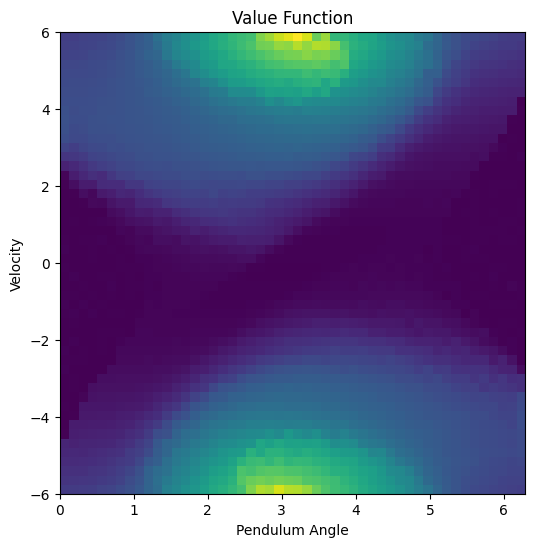

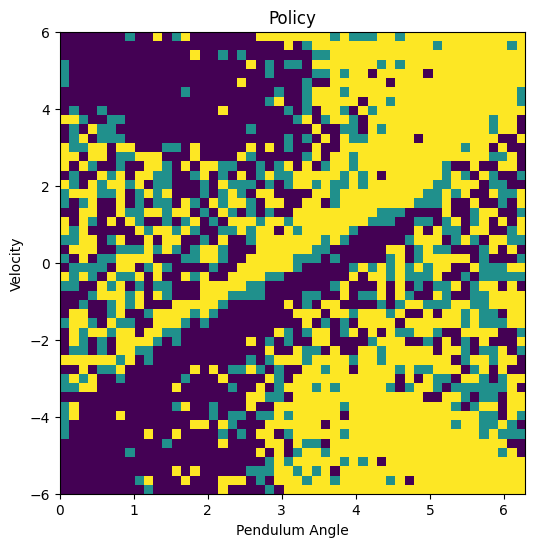

In [8]:
# we plot the value function
plt.figure(figsize=[6,6])
plt.imshow(VALUE_FUNCTION, extent=[0., 2*np.pi, -6, 6], aspect='auto')
plt.xlabel('Pendulum Angle')
plt.ylabel('Velocity')
plt.title('Value Function')

# we plot the policy
plt.figure(figsize=[6,6])
plt.imshow(POLICY, extent=[0., 2*np.pi, -6, 6], aspect='auto')
plt.xlabel('Pendulum Angle')
plt.ylabel('Velocity')
plt.title('Policy')

Text(0.5, 0, 'Time [s]')

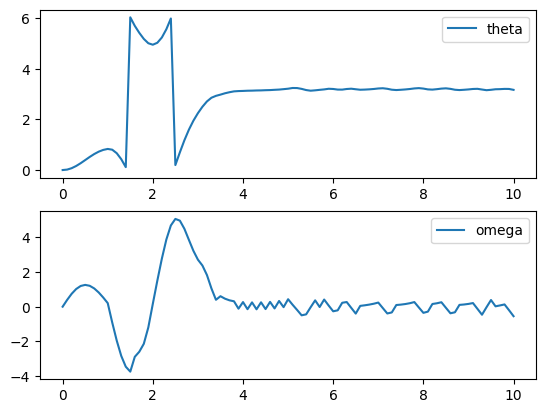

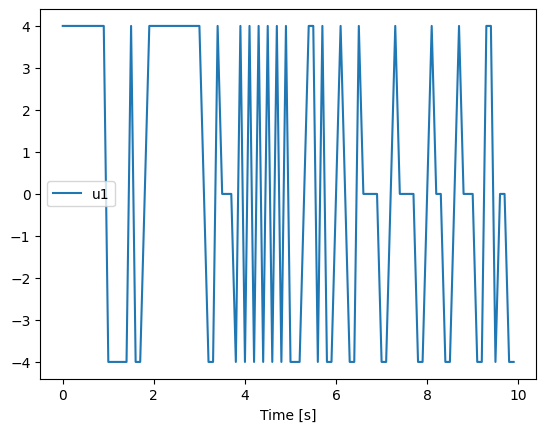

In [9]:
# we can plot the results
plt.figure()

plt.subplot(2,1,1)
plt.plot(t, x[0,:])
plt.legend(['theta'])

plt.subplot(2,1,2)
plt.plot(t, x[1,:])
plt.legend(['omega'])

# we can also plot the control
plt.figure()
plt.plot(t[:-1], u.T)
plt.legend(['u1'])
plt.xlabel('Time [s]')


Executing previous tasks using $u = [-5, 0, 5]$ just to see if any difference

In [10]:
DISCOUNT = 0.99
LEARNING_RATE = 0.1
EPSILON = 0.1
EPISODES = 10000
SIMULATION_TIME = 10
HORIZON_LENGTH = int(SIMULATION_TIME/DELTA_T)              # time = 10 seconds divided by delta_t = 0.1
INITIAL_STATE = [0, 0]

DISCRETE_WINDOWS = 50                                     # if increasing this, also increase EPISODES for a good result
DISCRETIZED_THETA = np.linspace(0, 2*np.pi, DISCRETE_WINDOWS, endpoint=False)
DISCRETIZED_OMEGA = np.linspace(-6, 6, DISCRETE_WINDOWS)
CONTROLS = [-5, 0, 5]

In [11]:
# Initializing Q-table
q_table = np.random.uniform(0, 2, size=(DISCRETE_WINDOWS, DISCRETE_WINDOWS, 3))

# Q-learning
learned_q_table, cost_per_episode = q_learning(q_table)

# Calculating the optimal policy and optimal value function
POLICY, VALUE_FUNCTION = get_policy_and_value_function(learned_q_table)

# Simulating the optimal policy
t, x, u = simulate(INITIAL_STATE, policy, SIMULATION_TIME)

# Visualizing the results
animate_robot(x)

<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAAfFltZGF0AAACrgYF//+q
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2MyByMzA2MCA1ZGI2YWE2IC0gSC4yNjQvTVBF
Ry00IEFWQyBjb2RlYyAtIENvcHlsZWZ0IDIwMDMtMjAyMSAtIGh0dHA6Ly93d3cudmlkZW9sYW4u
b3JnL3gyNjQuaHRtbCAtIG9wdGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFs
eXNlPTB4MzoweDExMyBtZT1oZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVk
X3JlZj0xIG1lX3JhbmdlPTE2IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBk
ZWFkem9uZT0yMSwxMSBmYXN0X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTMg
bG9va2FoZWFkX3RocmVhZHM9MSBzbGljZWRfdGhyZWFkcz0wIG5yPTAgZGVjaW1hdGU9MSBpbnRl
cmxhY2VkPTAgYmx1cmF5X2NvbXBhdD0wIGNvbnN0cmFpbmVkX2ludHJhPTAgYmZyYW1lcz0zIGJf
cHlyYW1pZD0yIGJfYWRhcHQ9MSBiX2JpYXM9MCBkaXJlY3Q9MSB3ZWlnaHRiPTEgb3Blbl9nb3A9
MCB3ZWlnaHRwPTIga2V5aW50PTI1MCBrZXlpbnRfbWluPTEwIHNjZW5lY3V0PTQwIGludHJhX3Jl
ZnJlc2g9MCByY19sb29rYWhlYWQ9NDAgcmM9Y3JmIG1idHJlZT0xIGNyZj0yMy4wIHFjb21wPTAu
NjAgcXBtaW49MCBxcG1heD02OSBxcHN0ZXA9NCBpcF9yYXRpbz0xLjQwIGFxPTE6MS4wMACAAAAM
+mWIhAA///73aJ8Cm1pDeoDklcUl20+B/6tncHyP6QMAAAMAAAMAABW3pGWGQnQv8mIAAAV8ALIG
ZJnpcUkTgA8wx7J03TT8KodCGFz3ILMf1XToD7aSZN8Zs9uaEA9jcSCQE44zxR7Qj2Eksq8+z+Wq
ZvqhqAmjtIUGvU4G5QJBAUbbGyaCYw38oY0EiqMUzXsdmysQKkUzaDNvexFsZpfdheEoKgGvZW8G
2fPtzPJdE33RzWsoHAbqHv7LUb1Fy2Yp1iQ19n08hwvr7IO0kg4fVQgC6P3/C57Zm0TDpNKoFwov
x46ywGgxxfs9fMlSyts++IhsON1YTXSZ+7DpOh9xNtWwLsYWvRnBU9gf4A7JwBQWOYAYmT3lcVdH
EKo8nPrWs29KQIrElzYOcOrbfLWcYFnRbvHGqlT+KBEQp3z6oWoiYMnqr8QIiolEN4vX5b2C+zQH
zQ2fvvWqjUvqvwklaEjJ+ye8BI4h+X6tXM23SjarA7G2VWJeukUYV1f6En/4Djaes3M+tPFDqIdw
mJGjR9bSRhckMp9qefU/tM9V9L10LQ/I2PakkxCGKNvJM+H+SynLT1OQzWCRGD85qKwirGqUtuvg
ZC3b9gA69LE4v6mtXXQrHNZ5SZV+X8rSJicGFTef9TB3gALLEFTdM8v6oymqpmy64kl+KEgZ+C32
PPkXdPfO2clgkdV/70ZvaxHfQP80q4e/Sd3feaMuZP0mS8OBVqZbuynp4BZ1E3zvfc0qlQAAAwAA
C/4EDImfLpXL0UYGG9I61Cmalvfh43hG3dLmz9oZ65pGNPkyV48tku4LcNUWF89BIjvtaoekCyFQ
ZiPqWo5ihWa3gcxBPUScHP6ABtF3xivrJpJIhwcLjwC3rP+QusDli2KhPgst/fSye+/wOU1Ju0vF
xqs6zXrdbC+bV/gIV6Zl4hBKMKg/E9lJnzHOREKARQi23LDIcvEW48ZsmaDlIu4wXBPBiiujCjPY
Hu9ETjKB7mQ74QPqDe6+Mcfy1O9nup++LMSZ/7CESW5MwfA80TLTfjL9lEJkWex6rVS5KvpfDwBI
+D14x66g2MFHmMnncYvnRbEG9/f/nSAGu+xh0ukyNn1JH4Js9jbgvwZXGDUsDmkINKWb+4iJDAqF
CX7cfD0/Oa7Vd98wf/VsLpUmtDJQhsHuKvENNLGfmQiUQOf2gM1C3YeVqj+q2Ouq0QqsEwenCAAA
AwAAAwAACFpTjIkiwvmHOGY7WU0IeZBQ2Llgjd5Teq/9xn8wirnq3kW3S9dKkE5TYBCHWTG93WmN
9sOjIup31+Otlj9v6PFgV5C6hYeCTo+c4EE+xTblz8bMRUbIAs7xsjI1hOOhLXiDP1X+a+xFJcSK
BjmMf9HcBJ8vKeqQOu2ujwZ80EXd0obQS/VrLJf39ia2H9ZncURAjuWs5gN7bX7li7EYY/vXobjc
GdPEyPR7kCHjttC0SSUkN/C7lUegaI09SZtbQgtiNZlZxI5c3mue0A1kNkJVF8HnI23UdfW163vh
Mf6BUle0u4h5ncFXQ+SBM2iNig//lAbaWYiRsRL9t3HYncTOJlsvpazitDYLP6KuZApvg1aIlvPl
yWjQGlOlv+tOiyR2WRV5KL2/AklkLEG+ZuyxkVtNKaKmkB5xNGzsH3CFCnQk/26nkAJnk3jXnPrh
1LNPLVRpvSIFZhLcTRcLKD0e9/NGxLZKUF8c3bw7NGBrq4Y6kw5N4PBc9MERHW0XRXVGR0X7lNF7
GToGw5KlLsryIu5TZ0hC42P/OTrECIidRNYOB4l24AoVos+L+1Frbd8/v5frDIMdz9pnteWLAuUR
SXfIlsc2Bn7tOshMMIIQMs+ewZf/FPdbZuRrz/6dFs+molGtg0Idf2mU9C7xjlm5oKE5hJc7Bd+P
n3wtdjVp6V2h5qEmDZY1BGmA9QoeApUW9ZvuxRxtJCkB0RLT3IAQ5k/A9WWtvYrfSsb97Qkjnyej
c9t4vpNo104qZz4jIHtZSUwWg4RCXMLJCoZSahr2Jw9ZUgmLvVIuyrZNzDYM992K/totzfpR5V5t
9gxszdZvut7opjWaQMOukAS1epQpknenrYQ/v7QQQI29rc0hfmeqsMwA5uW5pNNX0t/n21+5h3Cj
Y6K5hjCtxUVepWYi9bTih8h/WWELReUnKNzrLB0on4X/BT7Qx/Hw1BVsFaCNPglk5d6jZ5jBIStC
HvA9f6WbakB1ZsuPQ04Opd925DZ+bIYVNL89WWjpM68NPOeEUFCR51N78vVh3d9ZUP/jO8hPd+se
EbM4Pqf4CLsxEAH2j8s1C6fDVp2RwAACZaq33nKvDDf2FBV3v6NBjUSHizVAAv/+RyPReM6sgMes
lDaCyHPAMTe+ATF8v4fzwBDAAAP3t9G70El+j/5JNKj/jfKRwgYDyABjnJjrbNZ0k7gj7KN6WkiD
syc0tVVrLLu4yCtomp5u4M+Yao/Q/LjytYKh95zIR5kQgwKwc4FUxsejiDxT1sXKiGhtBhx0rMgy
tiSsb5X0yUXuEGoQp+o72qWPfybn2F6I++NLUs71m3edFL/jF8AIOZZKB86PKo7I4K/u86CGEyVP
Z5ynnc7WwO6hhQepo3RwAhx7UGg5y7eBNx1ZuNh/TOYyqjVbHzkqfm5kmUyCmK0A9uwE8TvCyDNh
ChAbSFVApNRgU9flZIfCuQWgmab/gKvtRTYdymGGjMgjGGQG1OOSN8fxaGTynvs86aclnuraR0cK
/+qdr9qtbn2Jwoc9rzbry9d6Gv/kh2N2ptZar46D0hACkkTtFagtwlEl7pC84D5mlysIlYEHGwXG
Xrw1JpP/kKsxeL2WxECbCnh4uYA6XoUnciUGJkIHBdBsgnNXd8qc7f3c3Zz1HxrpJL958igl+dcx
6/x/PKe4Li0Y1Yw8kLFhH

Text(0.5, 0, 'Episodes')

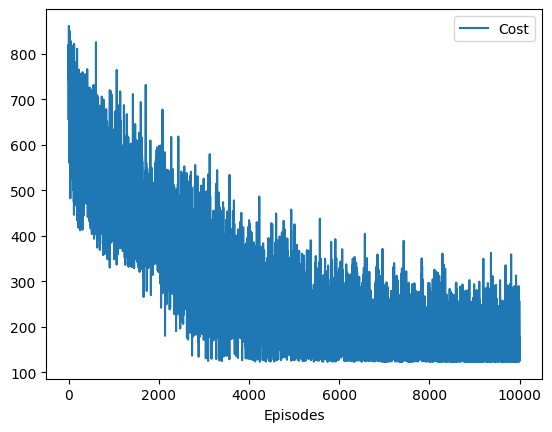

In [12]:
# we can plot the cost per episode
plt.figure()
plt.plot(cost_per_episode)
plt.legend(['Cost'])
plt.xlabel('Episodes')

Text(0.5, 1.0, 'Policy')

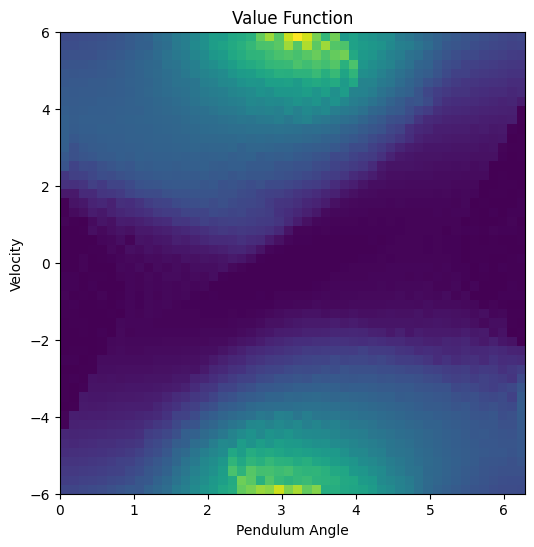

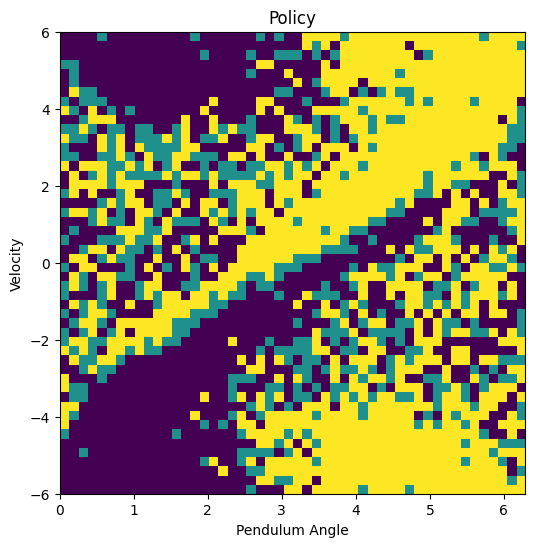

In [13]:
# we plot the value function
plt.figure(figsize=[6,6])
plt.imshow(VALUE_FUNCTION, extent=[0., 2*np.pi, -6, 6], aspect='auto')
plt.xlabel('Pendulum Angle')
plt.ylabel('Velocity')
plt.title('Value Function')

# we plot the policy
plt.figure(figsize=[6,6])
plt.imshow(POLICY, extent=[0., 2*np.pi, -6, 6], aspect='auto')
plt.xlabel('Pendulum Angle')
plt.ylabel('Velocity')
plt.title('Policy')

Text(0.5, 0, 'Time [s]')

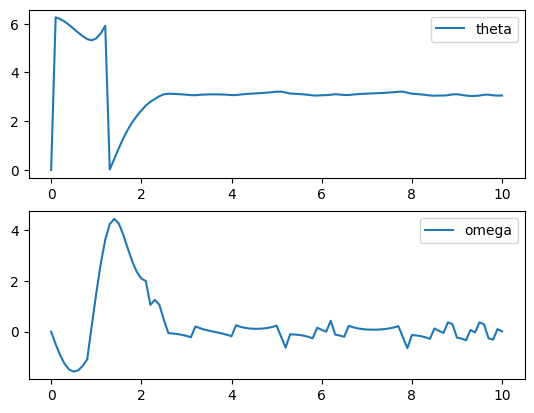

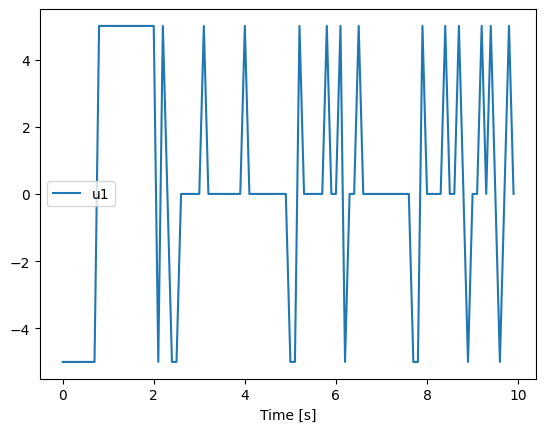

In [14]:
# we can plot the results
plt.figure()

plt.subplot(2,1,1)
plt.plot(t, x[0,:])
plt.legend(['theta'])

plt.subplot(2,1,2)
plt.plot(t, x[1,:])
plt.legend(['omega'])

# we can also plot the control
plt.figure()
plt.plot(t[:-1], u.T)
plt.legend(['u1'])
plt.xlabel('Time [s]')

#How is learning affected when changing $ϵ$ and the learning rate?

### Changing the epsilon

In [15]:
epsilon_range = np.arange(0.1, 0.51, 0.1)
print(epsilon_range)

[0.1 0.2 0.3 0.4 0.5]


In [16]:
state_list_epsilon = []
cost_per_episode_list = []
for e in epsilon_range:
  EPSILON = e
  # Initializing Q-table
  q_table = np.random.uniform(0, 2, size=(DISCRETE_WINDOWS, DISCRETE_WINDOWS, 3))

  # Q-learning
  _, cost_per_episode_epsilon = q_learning(q_table)

  cost_per_episode_list.append(cost_per_episode_epsilon)


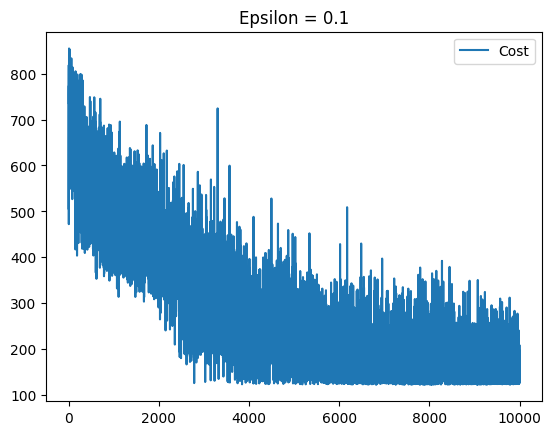

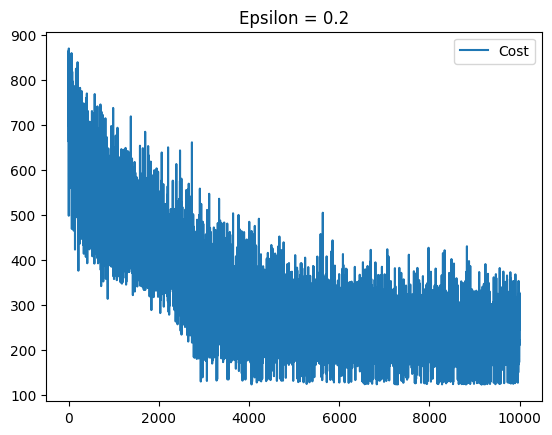

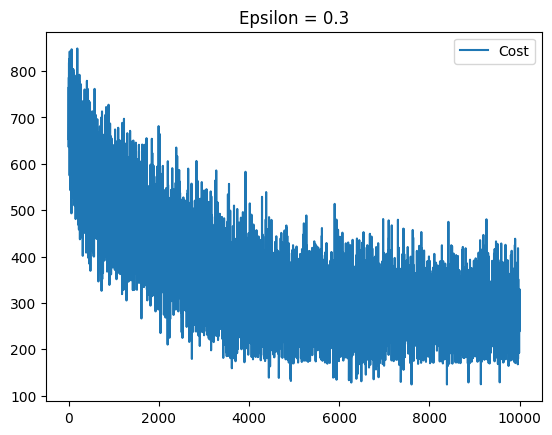

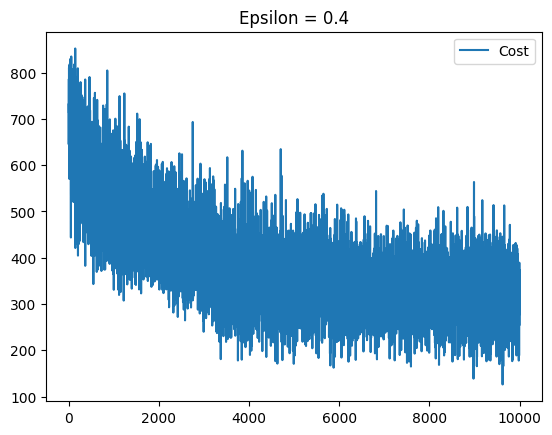

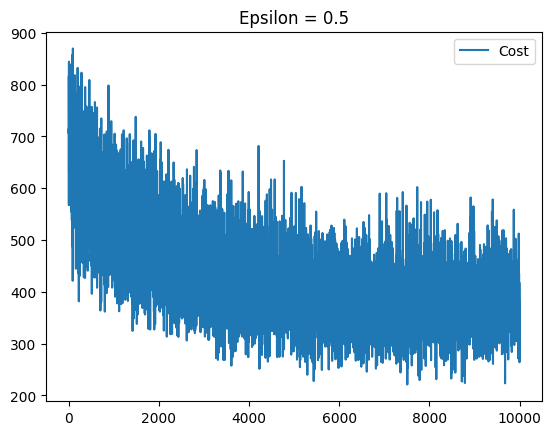

In [17]:
# we can plot the cost per episode for each epsilon

for i, e in enumerate(epsilon_range):
  plt.figure()
  plt.plot(cost_per_episode_list[i])
  plt.legend(['Cost'])
  plt.title('Epsilon = %0.1f' %e)


### Changing the learning rate

In [18]:
EPSILON = 0.1
learning_rate_range = np.arange(0.5, 2.1, 0.5)
print(learning_rate_range)

[0.5 1.  1.5 2. ]


In [19]:
state_list_gamma = []
cost_per_episode_list_gamma = []
for gamma in learning_rate_range:
  LEARNING_RATE = gamma
  # Initializing Q-table
  q_table = np.random.uniform(0, 2, size=(DISCRETE_WINDOWS, DISCRETE_WINDOWS, 3))

  # Q-learning
  _, cost_per_episode_gamma = q_learning(q_table)

  cost_per_episode_list_gamma.append(cost_per_episode_gamma)


<ipython-input-4-b4346bb40ced>:41: RuntimeWarning: overflow encountered in double_scalars
  Q_curr_updated = Q_curr + LEARNING_RATE*TD_error
<ipython-input-4-b4346bb40ced>:38: RuntimeWarning: invalid value encountered in double_scalars
  TD_error = cost_curr + DISCOUNT*min_Q_next - Q_curr
<ipython-input-4-b4346bb40ced>:41: RuntimeWarning: invalid value encountered in double_scalars
  Q_curr_updated = Q_curr + LEARNING_RATE*TD_error


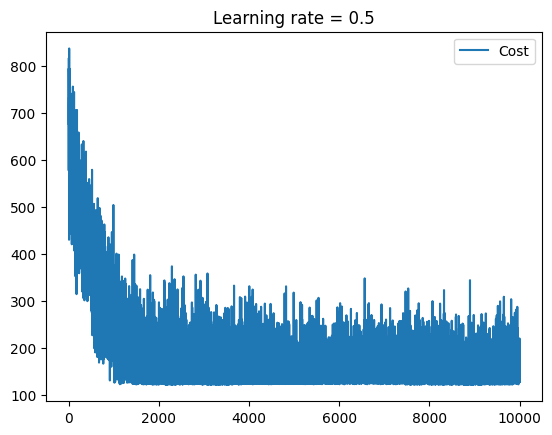

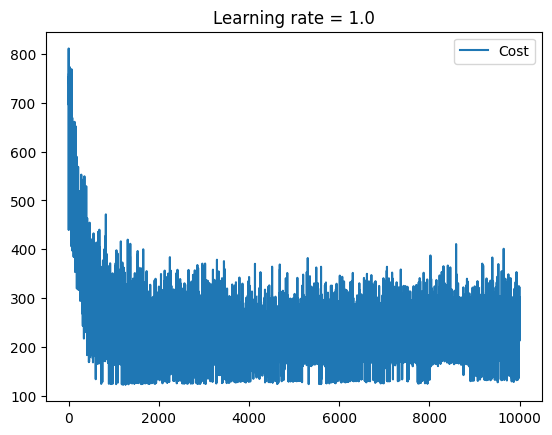

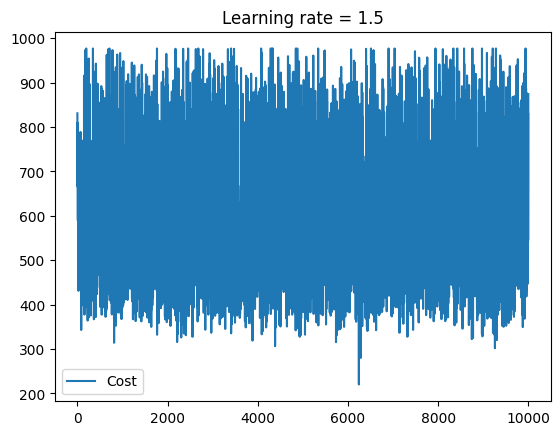

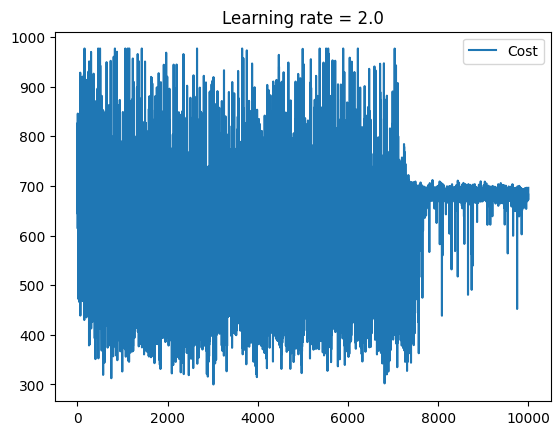

In [20]:
# we can plot the cost per episode for each epsilon
for i, gamma in enumerate(learning_rate_range):
  plt.figure()
  plt.plot(cost_per_episode_list_gamma[i])
  plt.legend(['Cost'])
  plt.title('Learning rate = %0.1f' %gamma)
